# Asymmetry tests

Hypothesis: the absolute value in the definition of asymmetry is **problematic**. CAS asymmetry is defined as:

$$ A = \frac{\sum |f - f^{180}|}{\sum |f| } - A_{bg}$$

where 

$$ A_{bg} = \frac{n_{obj}}{n_{sky}} \frac{\sum |f_{sky} - f_{sky}^{180}|}{\sum |f|}$$

so to expand, asymmetry is calculated as

$$ A = \frac{\sum |f - f^{180}| - \frac{n_{img}}{n_{sky}} \sum |f_{sky} - f_{sky}^{180}|}{\sum |f| } $$

This definition has a dependence on the noise, and therefore simply subtracting the background term doesn't account for all the noise in the image. The absolute value adds a correlation between the source asymmetry and the background term, even for a Gaussian background. If we used squared residuals rather than absolute residuals, this would not be a problem.

Changes to asymmetry that we test here:

1. Replace the residual calculation from absolute value to *squared*, which has a separable noise contribution
2. Add a correction term in the denominator that accounts for the contribution of BG flux to total
3. Change the initial guess for asymmetry center from center of flux to center of flux$^2$ for better performance
4. The rotation is done with **0th order interpolation**. Otherwise, the rotation applies interpolation which smoothes the image, reducing variance. Sky estimates are obtained without any rotation; so the sky asymmetry is always larger, than image asymmetry. When interpolation is turned off, the image variance is preserved after rotation. Also change the x-tolerance of the minimization to 0.5, since smaller tolerance doesn't make sense without interpolation.

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import fits
from astropy.visualization import simple_norm
from photutils import EllipticalAperture
import galsim

# from asymmetry import get_asymmetry
from galaxy_generator import gen_image, gen_galaxy, petrosian_sersic, create_clumps, add_source_to_image, sky_noise
from asymmetry import get_asymmetry, get_residual

In [2]:
plt.rcParams['font.size'] = 9
plt.rcParams['axes.xmargin'] = .05  # x margin.  See `axes.Axes.margins`
plt.rcParams['axes.ymargin'] = .05  # y margin.  See `axes.Axes.margins`

#### Utility functions

Set up the plot of CAS vs squared asymmetry as a function of a galaxy property

In [3]:
def plot_setup(xlabel='None'):
    fig = plt.figure(figsize=(6.7, 2.7))
    gs  = fig.add_gridspec(2, 5, wspace=0.05, hspace=0.01)
    ax11 = fig.add_subplot(gs[0,0:3])
    ax12 = fig.add_subplot(gs[0,3])
    ax13 = fig.add_subplot(gs[0,4])
    ax21 = fig.add_subplot(gs[1,0:3], sharex=ax11)
    ax22 = fig.add_subplot(gs[1,3])
    ax23 = fig.add_subplot(gs[1,4])
    
    ax11.tick_params(bottom=False, labelbottom=False)
    ax21.set_xlabel(xlabel); 
    ax11.set_ylabel('A (absolute)');
    ax21.set_ylabel('10x A (squared)');
    
    for ax in [ax12, ax13, ax22, ax23]:
        ax.axis('off')
        
    ax12.set_title('Image')
    ax13.set_title('Residual')
    return np.array([[ax11, ax12, ax13], [ax21, ax22, ax23]])

## Create SDSS-like image

Utility function to make an SDSS-like image using [**GalSim**](https://github.com/GalSim-developers/GalSim) and `galaxy_generator.py` functions.

Arguments:

* Basic properties
    * `mag`: source r-band magnitude
    * `r_eff`: source Sersic half-light radius in arcsec
    * `sky_mag`: sky surface brightness in mag/arcsec$^2$. Typical for SDSS r-band: 24.4
    * `psf_fwhm`: seeing in arcseconds (typical for SDSS *r*: 1.32)
    * `fov_reff`: field of view in units of the effective radius
* Source properties
    * `sersic_n`: Sersic index 
    * `q`: Axis ratio
    * `beta`: Orientation angle
* Asymmetric feature properties
    * `n_clumps`: number of asymmetric clumps to add to the image

**<font color='#aa33ff'>Questions:</font>**

1. Where do the telescope and transmission parameters come from?
2. What is the relevance of centre ra and dec?
3. What is 1 or n in `petrosian_sersic`?
4. Why are flux fractions logarithmically spaced?

**<font color='#aa33ff'>My changes:</font>**
1. Fix `gen_image` so that float values of `imsize` are rounded
2. Change clump generator so that the input positions are ($r$, $\theta$), where $r$ is the fraction of $R_{pet}$
3. Change clump generator so that the input positions are passed as a dictionary
4. Change clump generator so that the random clumps are generated between a certain range, which can be passed as a dictionary, including min/max boundaries on clump radial position, flux, and size
3. Change the PSF from sigma to FWHM, and make it so that no psf (FWHM=0) is an option

In [4]:
def get_perfect_galaxy(mag, r_eff, fov_reff=10, pxscale=0.396, sersic_n=1, q=1, beta=0, return_image=False):
    
    sdss_ra = 150
    sdss_dec = 2.3
    
    # Calculate field of view in degrees
    fov = fov_reff * r_eff / 3600
    
    # generate blank image with fov and wcs info
    field_image, wcs = gen_image(sdss_ra, sdss_dec, pxscale, fov, fov)

    # create a galaxy with given params
    galaxy = gen_galaxy(mag=mag, re=r_eff, n=sersic_n, q=q, beta=beta, telescope_params=telescope_params, 
                        transmission_params=transmission_params, bandpass=bandpass)
    
    # get petrosian radius of galaxy in px
    r_pet = petrosian_sersic(fov, r_eff, 1)/pxscale

    if return_image:
        pristine_image = add_source_to_image(field_image, galaxy, None, None, None, 0)
        return field_image, galaxy, r_pet, pristine_image.array
    else:
        return field_image, galaxy, r_pet

def get_realistic_galaxy(image, galaxy, r_pet, mag, sky_mag=23.7,  psf_fwhm=1.32, pxscale=0.396,
               n_clumps=10, clump_properties=None, random_clump_properties=None, rms_noise=True):

    # generate all the clumps and their positions
    clumps, all_xi, all_yi = create_clumps(image, r_pet, n_clumps, mag, telescope_params, transmission_params, bandpass,
                                           clump_properties, random_clump_properties)

    # convolve sources with psf and add to image
    image_psf = add_source_to_image(image, galaxy, clumps, all_xi, all_yi, psf_fwhm)

    if sky_mag:
        # add Poisson noise to image based on pixel counts with added sky level
        image_noise = sky_noise(image_psf, sky_mag, pxscale, telescope_params, transmission_params, bandpass, rms_noise=rms_noise)
    else:
        image_noise = image_psf
        
    # FINAL IMAGE IN ELECTRON COUNTS
    return image_noise.array

### Default SDSS parameters

In [5]:
## transmission curve based on sdss r-band total throughput for airmass=1.3 extended source
filt = 'r'
bandpass_file = "passband_sdss_" + filt
bandpass = galsim.Bandpass(bandpass_file, wave_type = u.angstrom)

## gain, exptime and diameter of telescope
telescope_params = {'g':4.8, 't_exp':53.91, 'D':2.5}
## effective wavelength and width of filter
transmission_params = {'eff_wav':616.5, 'del_wav':137}

sky_sdss = 23.7
pxscale_sdss = 0.396
psf_sdss = 1.32

### Typical galaxy

As an example, we can use [J0957-0012](https://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?id=1237651800697012233). It's a fairly typical (although post-starburst) z=0.04 galaxy. Compare with the real SDSS observation of the same galaxy.

In [6]:
# Source properties
mag_j0957 = 15.5
r_j0957 = 2
q_j0957 = 0.5

# Asymmetry clumps
clump_properties = {
    'r' : [2],
    'theta' : [0],
    'flux' : [0.3],
    'sigma' : [0.1]
}


field_image, galaxy, r_pet, pristine = get_perfect_galaxy(mag_j0957, r_j0957,  fov_reff=40, pxscale=pxscale_sdss, q=q_j0957, return_image=True)
img_sdss = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=sky_sdss, n_clumps=20, 
                                psf_fwhm=psf_sdss, clump_properties=clump_properties, rms_noise=True)

### Figure out the zeropoint

We have the pristine galaxy image in electron counts, and the desired magnitude, so we can figure out GalSim's zeropoint using $m = -2.5 \log F + \textrm{ZP}$.

In [7]:
ZP = mag_j0957 + 2.5 * np.log10(np.sum(pristine))
print(ZP)

30.469148635864258


### Compare to an SDSS galaxy

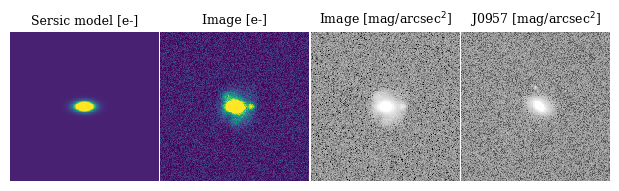

In [8]:
j0957_f = fits.open('/home/liza/work/data/sdss/frame-i-001473-3-0043.fits')
j0957 = j0957_f[0].data[170:370, 915:1115]
j0957_f.close()

fig, axs = plt.subplots(1, 4, figsize=(6,1.5))
axs[0].imshow(pristine, vmax=1000, vmin=-100)
axs[1].imshow(img_sdss, vmax=1000, vmin=-100)
axs[2].imshow(-2.5*np.log10(np.abs(img_sdss/pxscale_sdss**2))+ZP,     vmin=20, vmax=30, cmap='gray_r')
axs[3].imshow(-2.5*np.log10(np.abs(j0957/pxscale_sdss**2))+22.5, vmin=20, vmax=30, cmap='gray_r')
axs[0].set_title('Sersic model [e-]', size=9)
axs[1].set_title('Image [e-]', size=9)
axs[2].set_title(r'Image [mag/arcsec$^2$]', size=9)
axs[3].set_title(r'J0957 [mag/arcsec$^2$]', size=9)

for ax in axs: ax.axis('off')
plt.subplots_adjust(wspace=0.01)

## Test asymmetry functions

We want to compare different definitions of asymmetry and how they perform when varying 1) noise level, 2) PSF FWHM, 3) aperture size.

First, make a galaxy with a known asymmetry, no noise and no PSF, and measure its asymmetry.

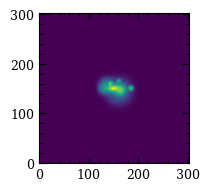

In [9]:
# Asymmetry clumps
clump_properties = {
    'r' : [3, 1.5, 1, 1.7, 1, 1.2, 1.2],
    'theta' : [0, 55, 125, 180, -30, 160, -15],
    'flux' : [0.3, 0.1, 0.4, 0.2, 0.7, 0.5, 2],
    'sigma' : [1, 1, 1, 2, 5, 3, 2]
}


field_image, galaxy, r_pet = get_perfect_galaxy(mag_j0957, r_j0957, fov_reff=60, pxscale=pxscale_sdss, q=q_j0957, return_image=False)
img_noiseless = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, 
                                     sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties)

fig = plt.figure(figsize=(1.5, 1.5))
plt.imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))

### Noiseless case

#### Asymmetry & aperture size

Check how asymmetry of the object changes with aperture size

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.33s/it]


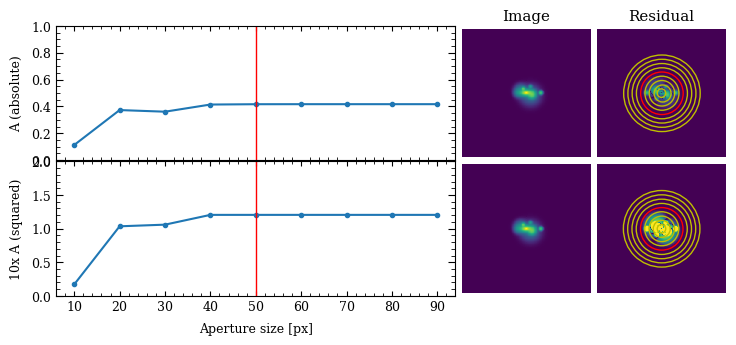

In [10]:
axs = plot_setup(xlabel='Aperture size [px]')
as_cas = []
as_sq  = []

# Plot the images
axs[0,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
axs[1,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))

ap_sizes = np.arange(10, 100, 10)
for ap_size in tqdm(ap_sizes, total=len(ap_sizes)):
    
    a_cas, x0_cas = get_asymmetry(img_noiseless, ap_size, 50, 'cas', 'residual', tol=0.1)
    a_sq, x0_sq = get_asymmetry(img_noiseless, ap_size, 50, 'squared', 'residual', tol=0.1)
    
    as_cas.append(a_cas)
    as_sq.append(a_sq)
    
    if ap_size == ap_sizes[0]:
        axs[0,2].imshow(get_residual(img_noiseless, x0_cas, 'cas'), norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
        axs[1,2].imshow(get_residual(img_noiseless, x0_cas, 'squared'), norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
    
    color = 'r' if ap_size == 50 else 'y'
    EllipticalAperture(x0_cas, ap_size, ap_size).plot(axes=axs[0,2], color=color, lw=1)
    EllipticalAperture(x0_sq,  ap_size, ap_size).plot(axes=axs[1,2], color=color, lw=1)


axs[0,0].plot(ap_sizes, as_cas, '.-')#, label='Circular ap')
axs[1,0].plot(ap_sizes, as_sq, '.-')#, label='Circular ap')
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,2)
for ax in axs[:,0]:
    ax.axvline(50, color='r', lw=1)

#### Strenth of the asymmetric feature

For this test, generate a single blob, and see how the asymmetry varies with the strength of the blob

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.07s/it]


(0.01, 9.9)

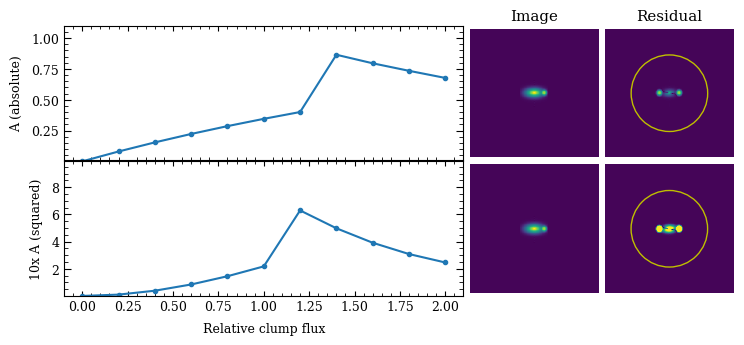

In [11]:
clump_properties = {'r' : [2], 'theta' : [0], 'sigma' : [1]}
clump_fluxes = np.linspace(0, 2, 11)

axs = plot_setup(xlabel='Relative clump flux')
as_cas = []
as_sq  = []

for f in tqdm(clump_fluxes, total=len(clump_fluxes)):
    
    clump_properties['flux'] = [f]
    img_noiseless = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=None, n_clumps=1, psf_fwhm=0, clump_properties=clump_properties)

    a_cas, x0_cas = get_asymmetry(img_noiseless, 50, 50, 'cas', 'residual', tol=0.1)
    a_sq, x0_sq = get_asymmetry(img_noiseless, 50, 50, 'squared', 'residual', tol=0.1)
    
    as_cas.append(a_cas)
    as_sq.append(a_sq)
    
    if f == clump_fluxes[5]:
        # Plot the images
        axs[0,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
        axs[1,1].imshow(img_noiseless, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
        axs[0,2].imshow(get_residual(img_noiseless, x0_cas, 'cas'), norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
        axs[1,2].imshow(get_residual(img_noiseless, x0_cas, 'squared'), norm=simple_norm(img_noiseless, stretch='log', log_a=1000))    
        EllipticalAperture(x0_cas, ap_size, ap_size).plot(axes=axs[0,2], color='y', lw=1)
        EllipticalAperture(x0_sq,  ap_size, ap_size).plot(axes=axs[1,2], color='y', lw=1)


axs[0,0].plot(clump_fluxes, as_cas, '.-')#, label='Circular ap')
axs[1,0].plot(clump_fluxes, as_sq, '.-')#, label='Circular ap')
axs[0,0].set_ylim(0.01,1.1)
axs[1,0].set_ylim(0.01,9.9)

Both show decent dynamic range, which is good, although asymmetry squared doesn't grow linearly with the feature flux like absolute asymmetry.

### Noise dependence

Now we add some noise, but still no PSF to see how asymmetry measurements change then.

First, define our galaxy properties again for this series of tests.

In [72]:
sky_mag = 23.7
pxscale = 0.396
psf = 0

mag = 15.5
r = 2
q = 0.5

clump_properties = {
    'r' : [3, 1.5, 1, 1.7, 1, 1.2, 1.2],
    'theta' : [0, 55, 125, 180, -30, 160, -15],
    'flux' : [0.3, 0.1, 0.4, 0.2, 0.7, 0.5, 2],
    'sigma' : [1, 1, 1, 2, 5, 3, 2]
}

field_image, galaxy, r_pet = get_perfect_galaxy(mag, r, fov_reff=60, pxscale=pxscale, q=q, return_image=False)
img_noiseless = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=psf, clump_properties=clump_properties)
img_noisy = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=sky_mag, n_clumps=len(clump_properties['r']), psf_fwhm=psf, clump_properties=clump_properties, rms_noise=True)


#### Minimization

Check that our minimization performs well and the solutions are stable. There are two issues with minimization in statmorph:

* Initial guess being the center of flux puts A at a local maximum, so the minimizer is more likely to reach a local rather than global minimum, since slope of A decreases on either side of the initial guess.

* `scipy.tansform.rotate` adds correlations in background noise. This means that the minimizer can find a center of rotation that exploits these correlations the most and set it as the center that minimizes asymmetry. We changed the rotation to use 0-order (no) interpolation. 

* Because we don't interpolate on rotation, there is no need for the extreme sub-pixel precision in finding the asymmetry center, so the x-tolerance can be decreased.

In [47]:
%%timeit
get_asymmetry(img_noisy, ap_size=50, bg_size=50, xtol=0.5, atol=1e-2)

0.2740 0.2740 0.2740 0.2740 0.2740 0.2740 0.2740 0.2740 1.78 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Constant noise; A vs. aperture size

Real asymmetry:

In [66]:
a_cas_real, x0_real = get_asymmetry(img_noiseless, 50, 50, 'cas', 'residual', xtol=0.5)
a_sq_real, _ = get_asymmetry(img_noiseless, 50, 50, 'squared', 'residual', xtol=0.5)

Test:

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.13it/s]


(0.0, 2.0)

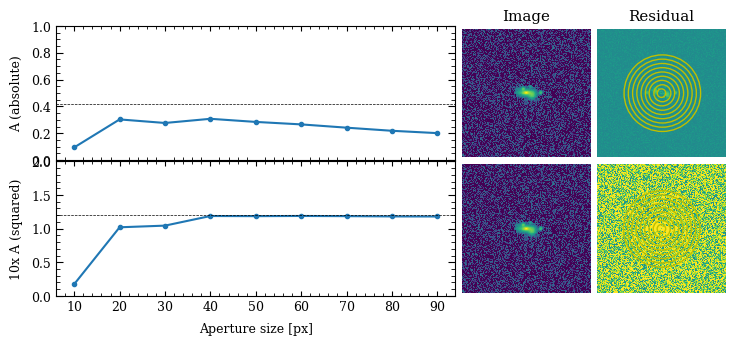

In [56]:
axs = plot_setup(xlabel='Aperture size [px]')
as_cas = []
as_sq  = []

# Plot the images
axs[0,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
axs[1,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))

ap_sizes = np.arange(10, 100, 10)
for ap_size in tqdm(ap_sizes, total=len(ap_sizes)):
    
    a_cas, x0_cas = get_asymmetry(img_noisy, ap_size, 50, 'cas', 'residual', xtol=0.5)
    a_sq, x0_sq = get_asymmetry(img_noisy, ap_size, 50, 'squared', 'residual', xtol=0.5)
    
    as_cas.append(a_cas)
    as_sq.append(a_sq)
    
    if ap_size == ap_sizes[0]:
        axs[0,2].imshow(get_residual(img_noisy, x0_cas, 'cas'), norm=simple_norm(img_noisy, stretch='log', log_a=1000))
        axs[1,2].imshow(get_residual(img_noisy, x0_cas, 'squared'), norm=simple_norm(img_noisy, stretch='log', log_a=1000))
    
    EllipticalAperture(x0_cas, ap_size, ap_size).plot(axes=axs[0,2], color='y', lw=1)
    EllipticalAperture(x0_sq,  ap_size, ap_size).plot(axes=axs[1,2], color='y', lw=1)


axs[0,0].plot(ap_sizes, as_cas, '.-')#, label='Circular ap')
axs[1,0].plot(ap_sizes, as_sq, '.-')#, label='Circular ap')
axs[0,0].axhline(a_cas_real, color='k', lw=0.5, ls='--')
axs[1,0].axhline(a_sq_real, color='k', lw=0.5, ls='--')
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,2)

Now with aperture correction term:

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.50it/s]


(0.0, 2.0)

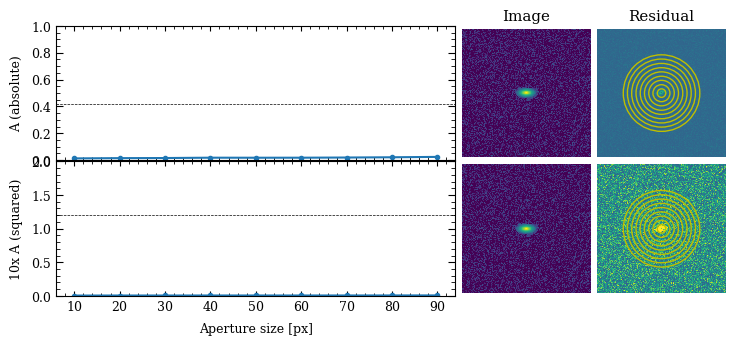

In [71]:
axs = plot_setup(xlabel='Aperture size [px]')
as_cas = []
as_sq  = []

# Plot the images
axs[0,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
axs[1,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))

ap_sizes = np.arange(10, 100, 10)
for ap_size in tqdm(ap_sizes, total=len(ap_sizes)):
    
    a_cas, x0_cas = get_asymmetry(img_noisy, ap_size, 60, 'cas', bg_corr='full', xtol=0.5)
    a_sq, x0_sq = get_asymmetry(img_noisy, ap_size, 60, 'squared', bg_corr='full', xtol=0.5)
    
    as_cas.append(a_cas)
    as_sq.append(a_sq)
    
    if ap_size == ap_sizes[0]:
        axs[0,2].imshow(get_residual(img_noisy, x0_cas, 'cas'), norm=simple_norm(img_noisy, stretch='log', log_a=1000))
        axs[1,2].imshow(get_residual(img_noisy, x0_cas, 'squared'), norm=simple_norm(img_noisy, stretch='log', log_a=1000))
    
    EllipticalAperture(x0_cas, ap_size, ap_size).plot(axes=axs[0,2], color='y', lw=1)
    EllipticalAperture(x0_sq,  ap_size, ap_size).plot(axes=axs[1,2], color='y', lw=1)


axs[0,0].plot(ap_sizes, as_cas, '.-')#, label='Circular ap')
axs[1,0].plot(ap_sizes, as_sq, '.-')#, label='Circular ap')
axs[0,0].axhline(a_cas_real, color='k', lw=0.5, ls='--')
axs[1,0].axhline(a_sq_real, color='k', lw=0.5, ls='--')
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,2)

### Asymmertry vs SNR

Combine these plots: look at how measured asymmetry changes as a function of the *average SNR per pixel* in a 50-pixel aperture (which captures all of the object's asymmetry).

In [80]:
num_sky_levels = 10
images_per_level = 10

as_cas = np.zeros((images_per_level, num_sky_levels))
as_sq  = np.zeros_like(as_cas)
snrs = []

bg_mag = np.linspace(19, 25, num_sky_levels)
for i, sky_mag in tqdm(enumerate(bg_mag), total=len(bg_mag)):

    for n in range(images_per_level):
        
        img_noisy = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=sky_mag, 
                                         n_clumps=len(clump_properties['r']), psf_fwhm=psf, clump_properties=clump_properties, rms_noise=True)

        a_cas, x0_cas = get_asymmetry(img_noisy, 50, 50, 'cas', bg_corr='full', xtol=0.5)
        a_sq, x0_sq = get_asymmetry(img_noisy, 50, 50, 'squared', bg_corr='full', xtol=0.5)

        as_cas[n,i] = a_cas
        as_sq[n,i] = a_sq

        # Calculate SNR
        if n == 0:
            
            ap_cas = EllipticalAperture(x0_cas, ap_size, ap_size)            
            ap_sq  = EllipticalAperture(x0_sq,  ap_size, ap_size)
            var = np.sqrt(np.std(img_noisy[:50,:50])**2 + img_noiseless)
            snr = img_noiseless/var
            snr = ap_cas.do_photometry(snr)[0][0] / ap_cas.do_photometry(np.ones_like(snr))[0][0]
            snrs.append(snr)

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]/home/liza/work/new_morphology/asymmetry.py:101: RuntimeWarning: divide by zero encountered in double_scalars
  a = (residual - ap_area*sky_a) / (total_flux - ap_area*sky_norm)
/home/liza/work/new_morphology/asymmetry.py:101: RuntimeWarning: divide by zero encountered in double_scalars
  a = (residual - ap_area*sky_a) / (total_flux - ap_area*sky_norm)
/home/liza/miniconda3/envs/astro/lib/python3.9/site-packages/scipy/optimize/_optimize.py:790: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/home/liza/work/new_morphology/asymmetry.py:101: RuntimeWarning: divide by zero encountered in double_scalars
  a = (residual - ap_area*sky_a) / (total_flux - ap_area*sky_norm)
/home/liza/miniconda3/envs/astro/lib/python3.9/site-packages/scipy/optimize/_optimize.py:790: RuntimeWarning: invalid value encountered in subtract
  np.

(0.0, 2.0)

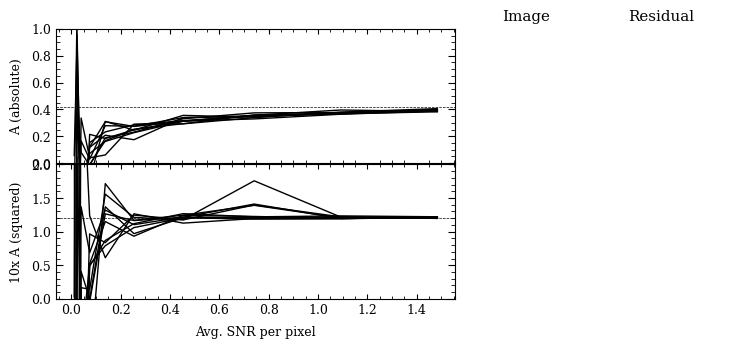

In [81]:

axs = plot_setup(xlabel='Avg. SNR per pixel')

# Plot the images
# axs[0,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))
# axs[1,1].imshow(img_noisy, norm=simple_norm(img_noiseless, stretch='log', log_a=1000))

for n in range(images_per_level):
    axs[0,0].plot(snrs, as_cas[n], '-', color='k', lw=1)#, label='Circular ap')
    axs[1,0].plot(snrs, as_sq[n], '-', color='k', lw=1)#, label='Circular ap')
axs[0,0].axhline(a_cas_real, color='k', lw=0.5, ls='--')
axs[1,0].axhline(a_sq_real, color='k', lw=0.5, ls='--')
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,2)

            
# if mag == 22:
#     ap_cas.plot(axes=axs[0,2], color='y', lw=1)
#     ap_cas.plot(axes=axs[1,2], color='y', lw=1)
#     axs[0,1].imshow(img_noiseless, norm=simple_norm(img_noisy, stretch='log', log_a=1000))
#     axs[1,1].imshow(img_noisy, norm=simple_norm(img_noisy, stretch='log', log_a=1000))
#     axs[0,2].imshow(get_residual(img_noisy, x0_cas, 'cas'), norm=simple_norm(img_noisy, stretch='log', log_a=1000))
#     axs[1,2].imshow(get_residual(img_noisy, x0_cas, 'squared'), norm=simple_norm(img_noisy, stretch='log', log_a=1000))

In [22]:
img_noisy = get_realistic_galaxy(field_image, galaxy, r_pet, mag, sky_mag=23.7, 
                                 n_clumps=len(clump_properties['r']), psf_fwhm=psf, clump_properties=clump_properties, rms_noise=True)

# img_noisy = np.random.normal(loc=0, scale=85, size=img_noisy.shape)
# img_noiseless = np.zeros_like(img_noisy)

# img_noisy = np.random.normal(loc=0, scale=95574.016, size=img_noiseless.shape)
res_real_cas = []
res_real_sq = []

flux_real_cas = []
flux_real_sq = []

res_cas = []
res_sq = []

flux_cas = []
flux_sq = []

bg_res_cas = []
bg_res_sq = []

bg_flux_cas = []
bg_flux_sq = []

ap_areas = []

ap_sizes = np.arange(15, 150, 15)
for ap_size in tqdm(ap_sizes, total=len(ap_sizes)):
    
    mask = T.rotate(np.ones_like(img_noisy), 180, center=x0_real, order=0)
    img_rot = T.rotate(img_noisy, 180, center=x0_real, order=0)
    img_real_rot = T.rotate(img_noiseless, 180, center=x0_real, order=0)
    sky = img_noisy[:50,:50]
    sigma = np.std(sky, ddof=1)
    ap = EllipticalAperture(x0_real, ap_size, ap_size)
    
    # Get real residual and flux in the aperture
    res_real_cas.append(ap.do_photometry(np.abs(img_noiseless - img_real_rot))[0][0])
    res_real_sq.append(ap.do_photometry((img_noiseless - img_real_rot)**2)[0][0])
    flux_real_cas.append(ap.do_photometry(np.abs(img_noiseless))[0][0])
    flux_real_sq.append(ap.do_photometry((img_noiseless)**2)[0][0])
    
    # Get uncorrected residual and flux
    res_cas.append(ap.do_photometry(np.abs(img_noisy - img_rot))[0][0])
    res_sq.append(ap.do_photometry((img_noisy - img_rot)**2, method='subpixel')[0][0])
    flux_cas.append(ap.do_photometry(np.abs(img_noisy))[0][0])
    flux_sq.append(ap.do_photometry((img_noisy)**2)[0][0])
    
    # Get background residual and flux
    ap_area = ap.do_photometry(np.ones_like(img_noisy))[0][0]
    ap_areas.append(ap_area)
    bg_area = sky.shape[0]*sky.shape[1]
    
    bg_res_cas.append( ap_area * np.mean(np.abs(sky-sky[::-1]))  )
    bg_res_sq.append(ap_area * np.mean((sky-sky[::-1])**2)  )
    bg_flux_cas.append( ap_area * np.mean(np.abs(sky))  )
    bg_flux_sq.append( ap_area * np.mean(sky**2)  )
    
    
res_real_cas  = np.array(res_real_cas )
res_real_sq   = np.array(res_real_sq  )
flux_real_cas = np.array(flux_real_cas)
flux_real_sq  = np.array(flux_real_sq )
res_cas       = np.array(res_cas      )
res_sq        = np.array(res_sq       )
flux_cas      = np.array(flux_cas     )
flux_sq       = np.array(flux_sq      )
bg_res_cas    = np.array(bg_res_cas   )
bg_res_sq     = np.array(bg_res_sq    )
bg_flux_cas   = np.array(bg_flux_cas  )
bg_flux_sq    = np.array(bg_flux_sq   )
ap_areas = np.array(ap_areas)

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.30it/s]


Text(0.5, 1.0, 'A$^2$')

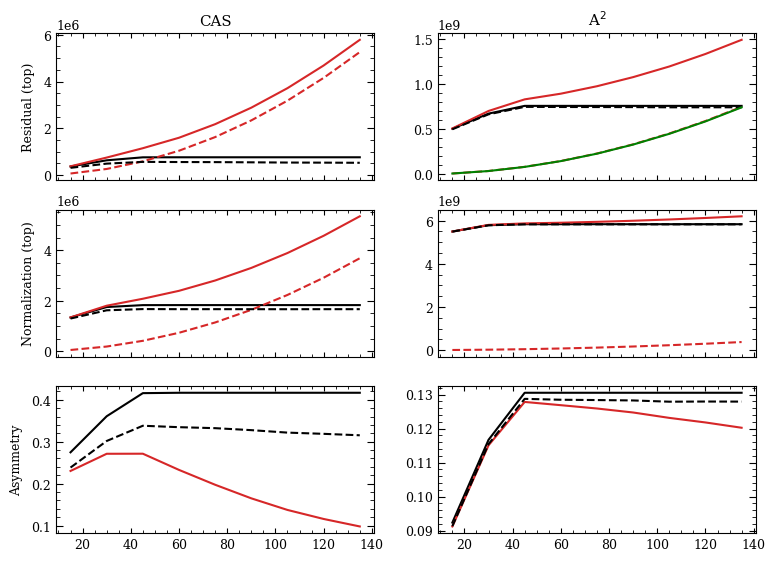

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True)

axs[0,0].plot(ap_sizes, res_real_cas, color='k', ls='-')
axs[0,0].plot(ap_sizes, res_cas, color='C3', ls='-')
axs[0,0].plot(ap_sizes, bg_res_cas, color='C3', ls='--')
axs[0,0].plot(ap_sizes, res_cas - bg_res_cas, color='k', ls='--')

axs[0,1].plot(ap_sizes, res_real_sq, color='k', ls='-')
axs[0,1].plot(ap_sizes, res_sq, color='C3', ls='-')
axs[0,1].plot(ap_sizes, bg_res_sq, color='C3', ls='--')
axs[0,1].plot(ap_sizes, res_sq - bg_res_sq, color='k', ls='--')
axs[0,1].plot(ap_sizes, ap_areas*2*sigma**2, color='g')

axs[1,0].plot(ap_sizes, flux_real_cas, color='k', ls='-')
axs[1,0].plot(ap_sizes, flux_cas, color='C3', ls='-')
axs[1,0].plot(ap_sizes, bg_flux_cas, color='C3', ls='--')
axs[1,0].plot(ap_sizes, flux_cas - bg_flux_cas, color='k', ls='--')

axs[1,1].plot(ap_sizes, flux_real_sq, color='k', ls='-')
axs[1,1].plot(ap_sizes, flux_sq, color='C3', ls='-')
axs[1,1].plot(ap_sizes, bg_flux_sq, color='C3', ls='--')
axs[1,1].plot(ap_sizes, flux_sq - bg_flux_sq, color='k', ls='--')

axs[2,0].plot(ap_sizes, res_real_cas / flux_real_cas, color='k', ls='-')
axs[2,0].plot(ap_sizes, (res_cas - bg_res_cas)/flux_cas, color='C3', ls='-')
axs[2,0].plot(ap_sizes, (res_cas - bg_res_cas)/(flux_cas-bg_flux_cas), color='k', ls='--')

axs[2,1].plot(ap_sizes, res_real_sq / flux_real_sq, color='k', ls='-')
axs[2,1].plot(ap_sizes, (res_sq - bg_res_sq)/flux_sq, color='C3', ls='-')
axs[2,1].plot(ap_sizes, (res_sq - bg_res_sq)/(flux_sq-bg_flux_sq), color='k', ls='--')

axs[0,0].set_ylabel('Residual (top)')
axs[1,0].set_ylabel('Normalization (top)')
axs[2,0].set_ylabel('Asymmetry')
axs[0,0].set_title('CAS')
axs[0,1].set_title(r'A$^2$')


In [87]:
sigma, np.std(img_noisy)

(85.41165198071175, 84.83160826585703)

In [88]:
theory = np.std(img_noisy)**2 * img_noisy.shape[0] * img_noisy.shape[1] * 2

In [89]:
np.sum( ( img_noisy - T.rotate(img_noisy, 180, center=x0_real) )**2 )/ theory

0.6660431731168592

$$ (f - f')^2 $$

In [ ]:
ap = EllipticalAperture(x0_real, 100, 100)
ap_area = ap.do_photometry(np.ones_like(img_noisy))[0][0]
theory = 2 * np.std(img_noisy)**2 * ap_area



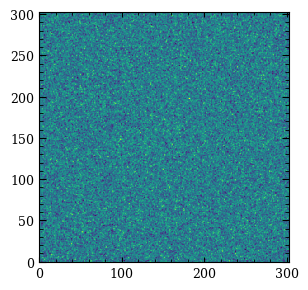

In [120]:

plt.imshow(tmp)

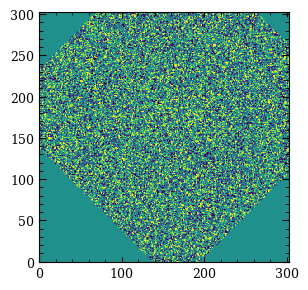

In [217]:
plt.imshow(tmp, vmax=100, vmin=-100)

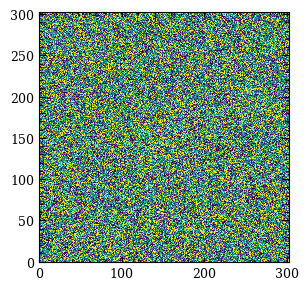

In [218]:
plt.imshow(img_noisy, vmax=100, vmin=-100)

In [319]:
cent = [200, 150.3]
tmp = T.rotate(img_noisy, 180, center=cent, order=0, preserve_range=False, clip=False, resize=False)
tmp_mask = T.rotate(np.ones_like(tmp), 180, center=cent, order=0, preserve_range=True)
tmp_mask = tmp_mask >= 0.1

# np.sum((img_noisy[tmp_mask]-tmp[tmp_mask])**2)/(2*np.std(img_noisy)**2 * np.sum(tmp_mask))

In [324]:
tmp2 = np.random.normal(loc=1, scale=1, size=img_noisy.shape)
tmp2_rot = T.rotate(tmp2, 180, center=cent, order=0, resize=False)

In [325]:
np.sum(tmp2_rot[tmp_mask]**2) / np.sum(tmp2[tmp_mask]**2)

0.9999999999999999

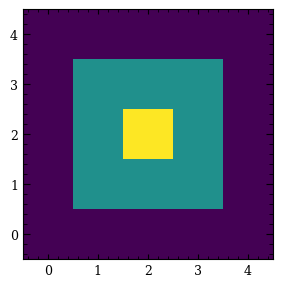

In [317]:
plt.imshow(tmp3)

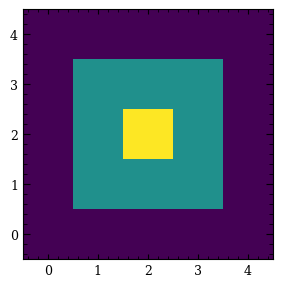

In [318]:
plt.imshow(tmp5)

In [286]:
image_180 = T.rotate(img_noisy, 180.0, center=cent)

# Apply symmetric mask
mask = np.zeros_like(img_noisy).astype(bool)
mask_180 = T.rotate(mask, 180.0, center=cent, cval=1)
mask_180 = mask_180 >= 0.5  # convert back to bool
mask_symmetric = mask | mask_180
image = np.where(~mask_symmetric, img_noisy, 0.0)
image_180 = np.where(~mask_symmetric, image_180, 0.0)

In [287]:
np.sum(image_180**2) / np.sum(image**2)

0.9999999999999312

In [27]:
img_rot = T.rotate(img_noisy, 180, center=tmp2)

ap = EllipticalAperture(tmp2, 120, 120)
ap_area = ap.do_photometry(np.ones_like(img_noisy))[0][0]
res = ap.do_photometry(np.abs(img_noisy-img_rot))[0][0]
flux =  ap.do_photometry(np.abs(img_noisy))[0][0]
sky_a = np.mean(np.abs(sky - sky[::-1]))

print(res)
print(sky_a * ap_area)
print(res - sky_a*ap_area)
print(flux)
print((res-sky_a*ap_area)/flux)


2488078.4174480643
2634950.064603967
-146871.6471559028
2936224.2562331455
-0.0500205823326053


In [28]:
img_rot = T.rotate(img_noisy, 180, center=x0_real)

ap = EllipticalAperture(x0_real, 120, 120)
ap_area = ap.do_photometry(np.ones_like(img_noisy))[0][0]
res = ap.do_photometry(np.abs(img_noisy-img_rot))[0][0]
flux =  ap.do_photometry(np.abs(img_noisy))[0][0]
sky_a = np.mean(np.abs(sky - sky[::-1]))

print(res)
print(sky_a * ap_area)
print(res - sky_a*ap_area)
print(flux)
print((res-sky_a*ap_area)/flux)


2920147.3960129707
2634967.8927842076
285179.5032287631
2936324.740813572
0.09712124114369856


In [41]:
np.sum(img_noisy) / (img_noisy.shape[0]**2 * np.std(sky))

0.4559107674207039

In [39]:
img_rot = T.rotate(img_noiseless, 180, center=tmp2)

ap = EllipticalAperture(tmp2, 120, 120)
res = ap.do_photometry(np.abs(img_noiseless-img_rot))[0][0]
flux =  ap.do_photometry(np.abs(img_noiseless))[0][0]

print(res)
print(flux)
print(res/flux)


434551.16792151687
1134109.2729430038
0.38316516608127216


In [ ]:
ap = EllipticalAperture(tmp2, 120, 120)
ap_area = ap.do_photometry(np.ones_like(img_noisy))[0][0]

In [ ]:
(ap.do_photometry(np.abs(img_noisy-img_rot))[0][0] - ap_area*np.mean(np.abs(sky-sky[::-1]))  )/ ap.do_photometry(np.abs(img_noisy))[0][0]